In [85]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
    

import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import grad, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value

from pu.pu_dynamics import *
from pu.load_data import *

import arviz as az
import seaborn as sns

sns.set_theme(palette="pastel")


import dill

%load_ext autoreload
%autoreload 2

az.style.use(["arviz-white", "arviz-royish"],)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
#Load saved data
data_path = "../data/" #Location where all data is stored
with open(data_path+'SVIdata.pkl', 'rb') as f:
    input_dict = dill.load(f)

dat = input_dict['dat']
ids = input_dict['ids']
model = input_dict['model']
auto_guide= input_dict['auto_guide']
params = input_dict['params']
posterior_samples = input_dict['posterior_samples']
svi_samples = input_dict['svi_samples']

/Users/vivekdharmangadansree/opt/miniconda3/envs/PUNumpyro/lib/python3.10/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (13). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


ValueError: cannot convert float NaN to integer

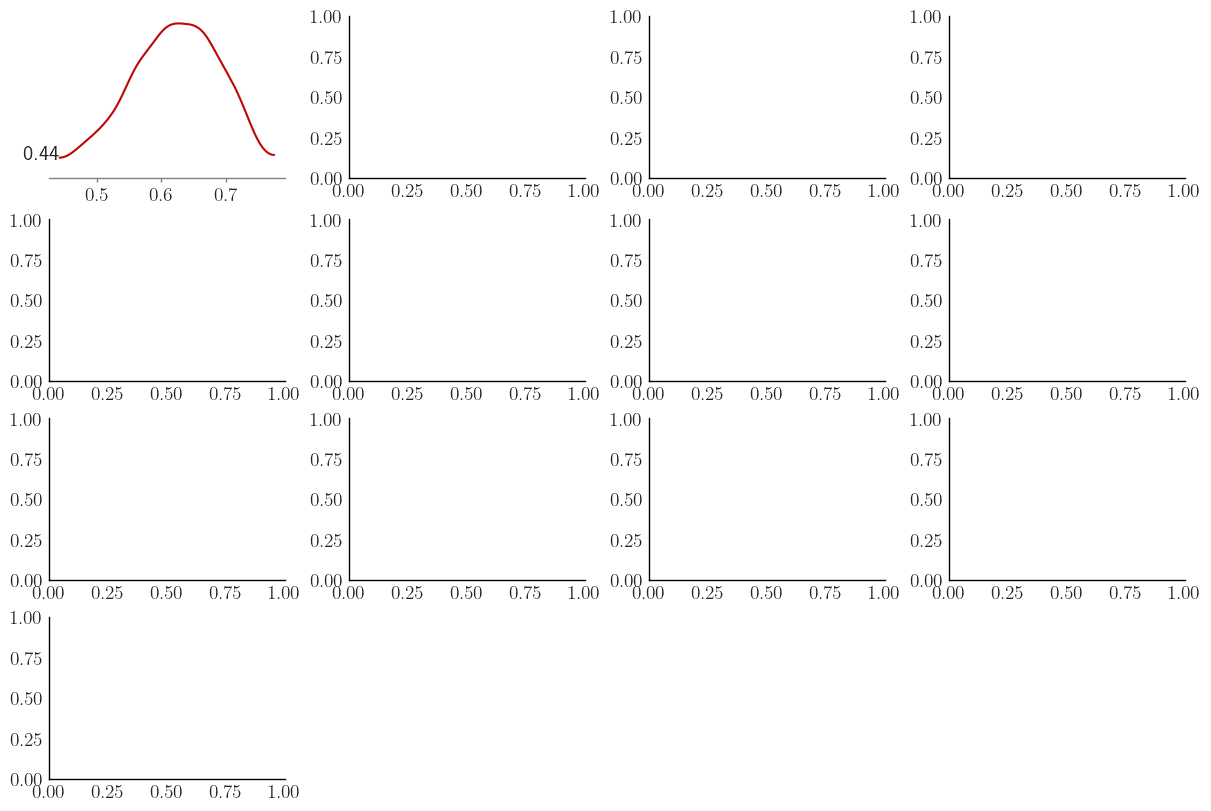

In [87]:
#posterior model parameter distributions

param_names = ["lkTa", "lnDa", "Tahf", "lm1Ta", "I1bhfm1", "lm1I1b", "Tbhfm1", "I1bhfm2", "lm2I1b", "sig1", "sig2", "sig3", "sig4"]
paramprint_names = [r"$\lambda_{k,Ta}$", r"$\lambda_{n,Da}$", r"$X_{m_1,Ta}$", r"$\lambda_{m_1,Ta}$", r"$X_{m_1,I1b}$", r"$\lambda_{m_1,I1b}$", r"$X_{m_1,Tb}$", r"$X_{m_2,Ilb}$", r"$\lambda_{m_2,I1b}$",
                    r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$"]

axes = az.plot_posterior(posterior_samples,var_names=param_names, grid=(4,4),figsize=(12,8))

axf = axes.flatten()
for i in range(len(param_names)):
    axf[i].set_title(paramprint_names[i],fontsize=20)

plt.tight_layout()
# plt.savefig(data_path+"PosteriorParameters",dpi=300)
plt.show()

/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_31468/2858925086.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


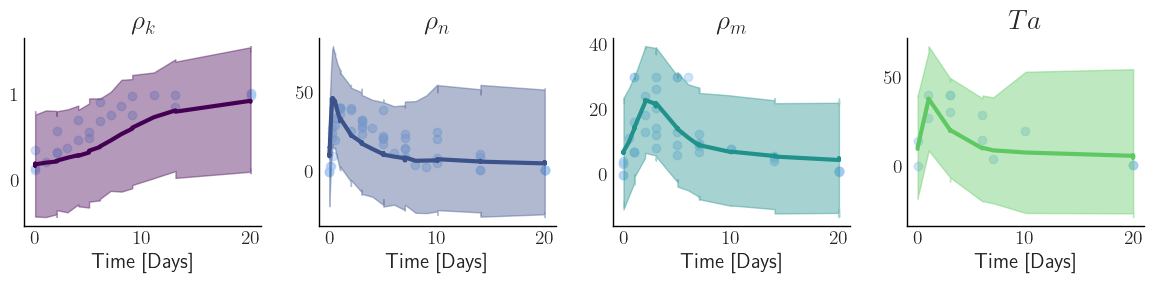

In [88]:
species = ["y_rhok", "y_rhon",  "y_rhom", "y_ta"]
species_printname = [r"$\rho_{k}$", r"$\rho_{n}$", r"$\rho_{m}$", r"$Ta$"]

timel = jnp.linspace(0,480,480)

cmap2 = matplotlib.cm.get_cmap('viridis', 5)

fig, ax = plt.subplots(1,4,figsize=(12,3))
axef = ax.flatten()

for i in range(len(species)):
    vals  = svi_samples[species[i]]
    mu = jnp.mean(vals, axis=0)
    pi = jnp.percentile(vals, jnp.array([2.5,97.5]), axis=0)
    axef[i].scatter(dat[i][:,0],dat[i][:,2],color = 'b',alpha=0.5)
    axef[i].plot(timel[ids[i]]/24., mu, color = cmap2(i) ,lw = 3.0)
    axef[i].fill_between(timel[ids[i]]/24., pi[0,:], pi[1,:], color = cmap2(i),alpha=0.4)
    axef[i].set_title(species_printname[i], fontsize=20)
    axef[i].set_xlabel("Time [Days]")
    
plt.tight_layout()
# plt.savefig(data_path+"PosteriorDynamics",dpi=300)
plt.show()

DeviceArray([ 0.,  0.,  0.,  1.,  2.,  2.,  2.,  3.,  4.,  4.,  5.,  5.,
              6.,  6.,  7.,  8.,  9.,  9., 11., 13., 13., 20., 20., 20.],            dtype=float32)

In [56]:
svi_samples[species[1]]

DeviceArray([[ 31.277187  ,  -9.746577  ,  12.506386  , ...,
               -0.34659332,   4.7819204 ,   3.6862655 ],
             [ 17.924301  ,  30.031723  ,   0.10734666, ...,
                7.6448874 ,  13.185168  ,  12.760398  ],
             [  7.4250417 ,  -5.745581  ,  17.725903  , ...,
               -2.7041166 ,  -8.085135  ,  20.726685  ],
             ...,
             [  7.3458953 ,   3.5669978 ,  40.348625  , ...,
                1.9153175 ,  25.322773  , -29.377337  ],
             [ -5.233743  ,  34.859207  ,  13.864193  , ...,
                6.603459  , -26.788969  , -21.750015  ],
             [  6.1013985 ,  12.374313  ,  11.07603   , ...,
               -4.7552013 , -22.486166  ,   9.2310705 ]], dtype=float32)